In [1]:
!pip3 install gymnasium
# !pip install swig
# !pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.6 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from collections import deque
import random

from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Working with {device}")

Working with cpu


In [3]:
class FCQV(nn.Module):
    def __init__(self, input_dim, hidden_dims=(32, 32), activation_fc = nn.ReLU()):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc
        self.layers = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers.append(self.activation_fc)
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.layers.append(self.activation_fc)
        self.layers.append(nn.Linear(hidden_dims[-1], 1))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, state, action):
        x = state
        y = action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)

        z = torch.cat((x, y), dim = 1).to(device).to(torch.float32)

        return self.layers(z)

class FCDP(nn.Module):
    def __init__(self, input_dim, action_bounds, hidden_dims=(32, 32), activation_fc = nn.ReLU(), out_activation = nn.Tanh()):
        super(FCDP, self).__init__()
        self.env_min, self.env_max = torch.Tensor(action_bounds[0]).to(device), torch.Tensor(action_bounds[1]).to(device)
        self.activation_fc = activation_fc
        self.out_activation = out_activation
        self.layers = [(nn.Linear(input_dim, hidden_dims[0]))]

        for i in range(len(hidden_dims) - 1):
            self.layers.append(self.activation_fc)
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.layers.append(self.activation_fc)
        self.layers.append(nn.Linear(hidden_dims[-1], len(self.env_max)))
        self.layers.append(self.out_activation)
        self.layers = nn.Sequential(*self.layers)


    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        out= self.layers(x)

        return self.rescale(out)

    def rescale(self, out):
        return (out + 1)*(self.env_max - self.env_min) / (2) + self.env_min




In [4]:
class NormalNoiseDecayStrategy():
    def __init__(self, bounds, init_noise_ratio=0.4, min_noise_ratio=0.05, decay_steps=10000):
        self.t = 0
        self.low, self.high = bounds
        self.noise_ratio = init_noise_ratio
        self.init_noise_ratio = init_noise_ratio
        self.min_noise_ratio = min_noise_ratio
        self.decay_steps = decay_steps

    def _noise_ratio_update(self):
        noise_ratio = 1 - self.t / self.decay_steps
        noise_ratio = (self.init_noise_ratio - self.min_noise_ratio) * noise_ratio + self.min_noise_ratio
        noise_ratio = np.clip(noise_ratio, self.min_noise_ratio, self.init_noise_ratio)
        self.t += 1
        return noise_ratio

    def select_action(self, model, state, max_exploration=False):
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.noise_ratio * self.high

        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)

        self.noise_ratio = self._noise_ratio_update()
        return action

In [5]:
class ReplayBuffer:
    def __init__(self, max_len):
        self.experiences = deque(maxlen = max_len)

    def add_experience(self, state, action, reward, next_state, is_terminal):
        self.experiences.append((state, action, reward, next_state, is_terminal))

    def get_batch_experince(self, batch_size):
        batch = random.sample(self.experiences, batch_size)
        states = np.array([i[0] for i in batch])
        actions = np.array([i[1] for i in batch])
        rewards = np.array([i[2] for i in batch])
        next_states = np.array([i[3] for i in batch])
        is_terminals = np.array([i[4] for i in batch])
        return (tuple([states, actions, rewards, next_states, is_terminals]))


In [8]:
class DDPG:
    def __init__(self, env, gamma, replay_buffer_size, batch_size, hidden_dims, policy_optimizer, value_optimizer, tau, update_steps, decay_steps, lr = (1e-4, 1e-4)):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.replaybuffer = ReplayBuffer(replay_buffer_size)
        self.batch_size = batch_size
        self.update_steps = update_steps
        self.decay_steps = decay_steps

        nS, nA = self.env.observation_space.shape[0], self.env.action_space.shape[0]
        action_bounds = self.env.action_space.low, self.env.action_space.high
        self.online_value_model = FCQV(nS + nA, hidden_dims[0]).to(device)
        self.target_value_model = FCQV(nS + nA, hidden_dims[0]).to(device)
        self.online_policy_model = FCDP(nS, action_bounds, hidden_dims[1]).to(device)
        self.target_policy_model = FCDP(nS, action_bounds, hidden_dims[1]).to(device)
        self.update_model(tau = 1.0)
        self.env.reset()

        self.value_optimizer = value_optimizer(self.online_value_model.parameters(), lr[0])
        self.policy_optimizer = policy_optimizer(self.online_policy_model.parameters(), lr[1])

        self.action_policy = NormalNoiseDecayStrategy(action_bounds, decay_steps = self.decay_steps)

        self.returns = deque(maxlen = 100)

    def update_model(self, tau = None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), self.online_value_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(), self.online_policy_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        states = torch.from_numpy(states).to(device)
        actions = torch.from_numpy(actions).to(device)
        next_states = torch.from_numpy(next_states).to(device)
        rewards = torch.from_numpy(rewards).to(device).unsqueeze(0).T
        is_terminals = torch.from_numpy(is_terminals).to(device).unsqueeze(0).T

        argmax_a_q_sp = self.target_policy_model(next_states)
        max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
        target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)


        q_sa = self.online_value_model(states, actions)
        td_error = q_sa - target_q_sa.detach()
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        argmax_a_q_s = self.online_policy_model(states)
        max_a_q_s = self.online_value_model(states, argmax_a_q_s)
        policy_loss = -max_a_q_s.mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

    def interactive_step(self, state):
        action = self.action_policy.select_action(self.target_policy_model, state)
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        self.replaybuffer.add_experience(state, action, reward, new_state, int(terminated and not truncated))
        return new_state, terminated or truncated

    def train(self, num_steps, step, evals, goal):
        epis = 1
        terminated = False
        state = self.env.reset()[0]
        for i in tqdm(range(1, num_steps + 1)):
            state, terminated = self.interactive_step(state)
            if(len(self.replaybuffer.experiences) > self.batch_size):
                self.optimize_model(self.replaybuffer.get_batch_experince(self.batch_size))
            if(terminated):
                epis += 1
                state = self.env.reset()[0]
                if(epis % step == 0):
                    if(self.evaluate(evals, goal)):
                        torch.save(self.target_policy_model.state_dict(), f'./{i/step}_iteration_target_policy.pth')
                        torch.save(self.target_value_model.state_dict(), f'./{i/step}_iteration_target_value.pth')
                        return
            if(num_steps % self.update_steps == 0):
                self.update_model()

    def evaluate(self, evals, goal):
        for _ in range(evals):
            state = self.env.reset()[0]
            terminated = False
            return_val = 0
            while(not terminated):
                # img = self.env.render()
                # cv2.imshow("Environment", img)
                # cv2.waitKey(1)
                action = self.target_policy_model(state).detach().cpu()
                state, reward, terminate, truncated, _ = self.env.step(action[0])
                terminated = truncated or terminate
                return_val += reward
            self.returns.append(return_val)

        # cv2.destroyAllWindows()
        _mean = np.mean(list(self.returns)[-evals:])
        print(f"\nMean return value of last {evals} evaluations = {_mean}")
        plt.plot(range(len(self.returns)), self.returns)
        plt.show()
        return (goal <= _mean)


  0%|          | 789/400000 [00:06<1:00:30, 109.96it/s]


Mean return value of last 5 evaluations = -1826.3109130859375


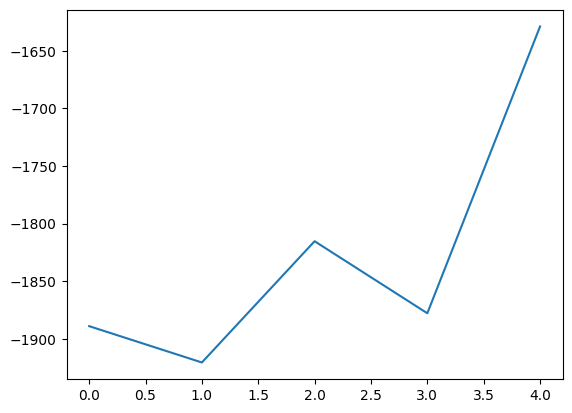

  0%|          | 1595/400000 [00:16<1:03:27, 104.64it/s]


Mean return value of last 5 evaluations = -1526.386474609375


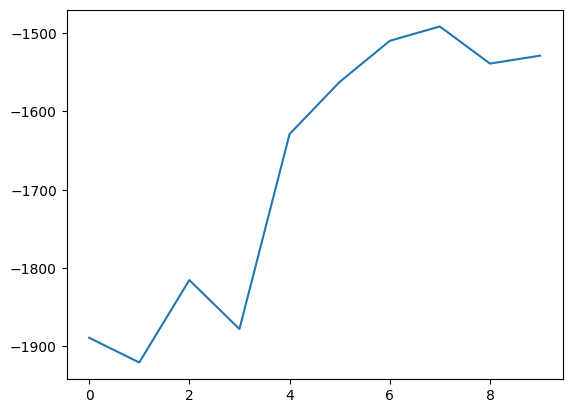

  1%|          | 2401/400000 [00:25<1:30:18, 73.38it/s]


Mean return value of last 5 evaluations = -1494.7353515625


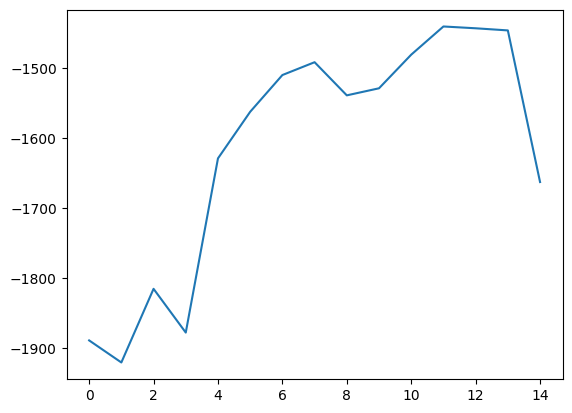

  1%|          | 3197/400000 [00:33<1:04:31, 102.49it/s]


Mean return value of last 5 evaluations = -1433.06201171875


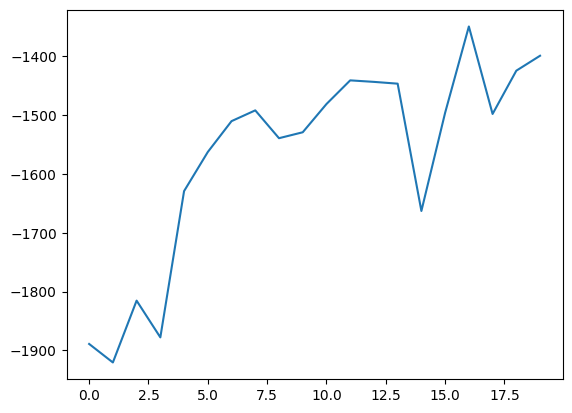

  1%|          | 3993/400000 [00:42<1:02:21, 105.83it/s]


Mean return value of last 5 evaluations = -1341.467529296875


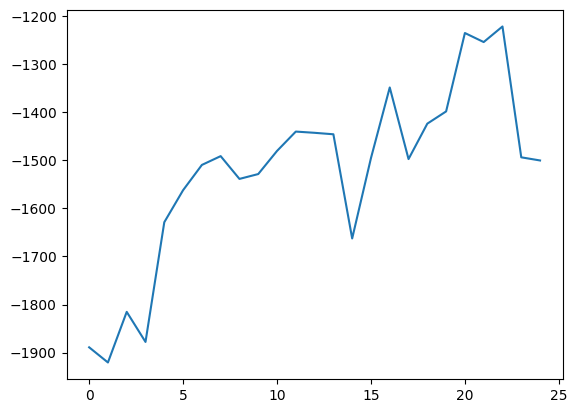

  1%|          | 4794/400000 [00:52<1:11:42, 91.86it/s]


Mean return value of last 5 evaluations = -1076.6875


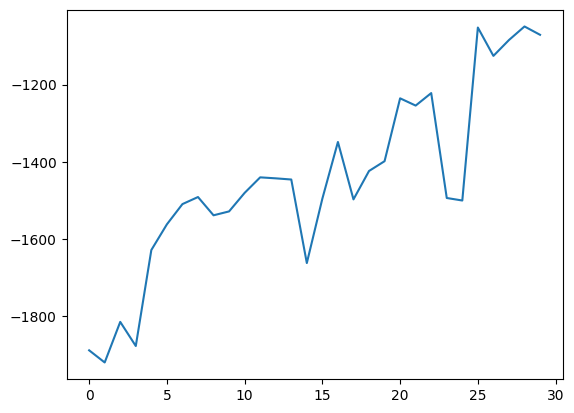

  1%|▏         | 5600/400000 [01:00<1:01:27, 106.97it/s]


Mean return value of last 5 evaluations = -1061.675048828125


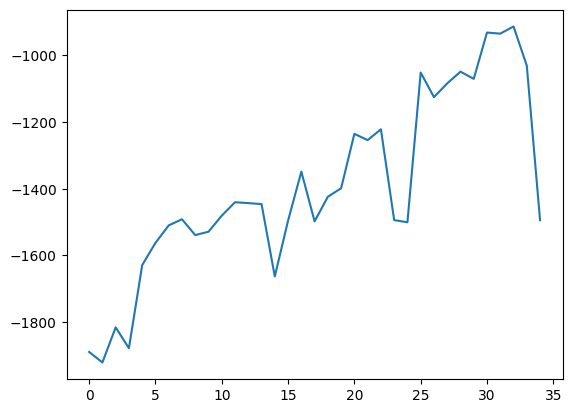

  2%|▏         | 6405/400000 [01:10<1:01:48, 106.13it/s]


Mean return value of last 5 evaluations = -759.0569458007812


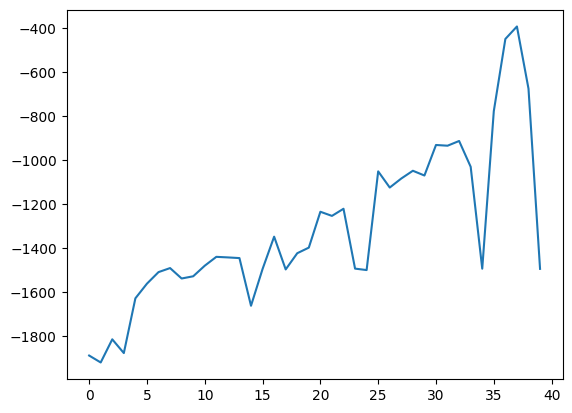

  2%|▏         | 7207/400000 [01:19<1:04:04, 102.17it/s]


Mean return value of last 5 evaluations = -264.38525390625


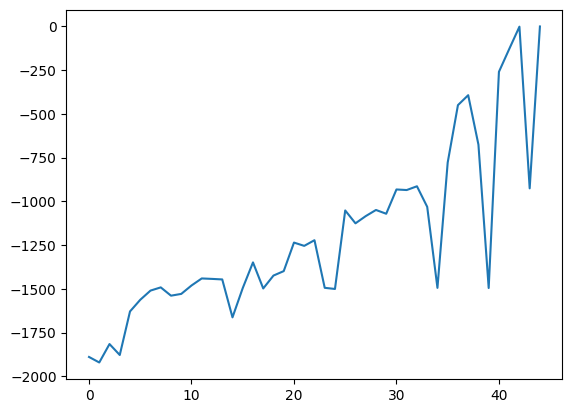

  2%|▏         | 8001/400000 [01:29<1:34:24, 69.21it/s]


Mean return value of last 5 evaluations = -323.23980712890625


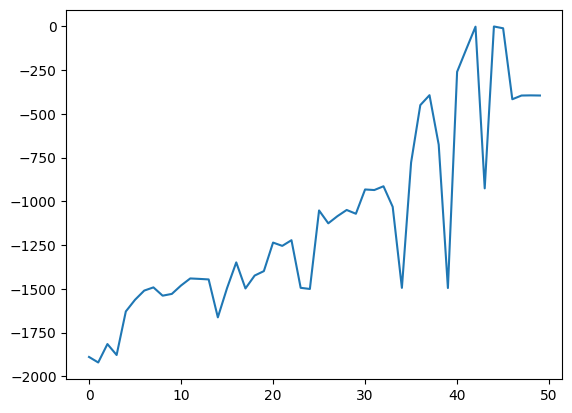

  2%|▏         | 8802/400000 [01:38<1:02:24, 104.48it/s]


Mean return value of last 5 evaluations = -362.4412536621094


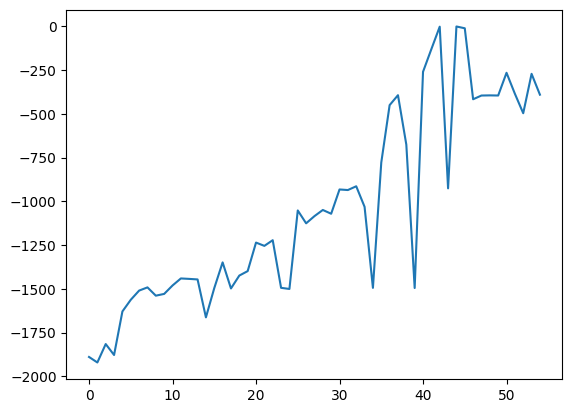

  2%|▏         | 9604/400000 [01:47<1:01:28, 105.83it/s]


Mean return value of last 5 evaluations = -185.4632568359375


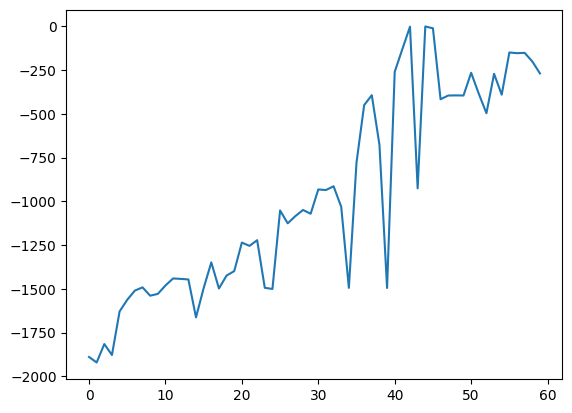

  2%|▏         | 9610/400000 [01:48<1:13:41, 88.29it/s] 


In [9]:
ENV = "Pendulum-v1"
env = gym.make(ENV)

GAMMA = 0.99
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
HIDDEN_DIMS = ((256, 128, 64), (256, 128, 64))
TAU = 2e-3
UPDATE_EVERY = 1
LR = (1e-3, 1e-3)
DECAY_STEPS = int(5e4)


agent = DDPG(env, GAMMA, BUFFER_SIZE, BATCH_SIZE, HIDDEN_DIMS, optim.Adam, optim.Adam, TAU, UPDATE_EVERY, DECAY_STEPS, LR)

TIME_STAMPS = int(4e5)
STEP = 5
EVAL = 5
GOAL = -250
agent.train(TIME_STAMPS, STEP, EVAL, GOAL)
agent.env.close()